Notebook with a simple attempt to replace b(u) function with input convex neural network. Original loss function is taken from [here](https://github.com/vistalab-technion/vqr)

In [19]:
import torch
from torch import nn

class BetaNetwork(torch.nn.Module):
    """Input Convex Neural Network for beta potential estimation"""

    def __init__(self, input_dimension: int, hidden_dimension: int, num_hidden_layers: int, output_dimension: int):
        super().__init__()

        Wzs = []
        Wzs.append(nn.Linear(input_dimension, hidden_dimension))
        for _ in range(num_hidden_layers - 1):
            Wzs.append(torch.nn.Linear(hidden_dimension, hidden_dimension, bias=False))
        Wzs.append(torch.nn.Linear(hidden_dimension, 1, bias=False))
        self.Wzs = torch.nn.ModuleList(Wzs)

        Wxs = []
        for _ in range(num_hidden_layers - 1):
            Wxs.append(nn.Linear(input_dimension, hidden_dimension))
        Wxs.append(nn.Linear(input_dimension, output_dimension, bias=False))
        self.Wxs = torch.nn.ModuleList(Wxs)
        self.act = nn.Softplus()

    def forward(self, x):
        z = self.act(self.Wzs[0](x))
        for Wz, Wx in zip(self.Wzs[1:-1], self.Wxs[:-1]):
            z = self.act(Wz(z) + Wx(x))
        return self.Wzs[-1](z) + self.Wxs[-1](x)

In [20]:
def torch_sphere_uniform(n, d, **kwargs):
    """Generate n points inside the d-dimensional sphere."""
    random_vectors = torch.randn(n, d, **kwargs)
    vectors_norms = torch.norm(random_vectors, dim=1, keepdim=True)
    radius = torch.pow(torch.rand(n, 1, **kwargs), 1. / d)
    return radius * random_vectors / vectors_norms

In [21]:
from data_utils import create_joint_x_y
import numpy as np

num_points_to_generate = 1000

X, Y = create_joint_x_y(num_points_to_generate)

n, d = Y.shape
m = n

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

potential_network = BetaNetwork(d + X.shape[1], 2, 2, 1)

In [14]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 0.1
num_epochs = 2000

Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
X_tensor = torch.tensor(X, **device_and_dtype_specifications) - 1.5
nu_tensor = torch.tensor(nu, **device_and_dtype_specifications)
mu_tensor = torch.tensor(mu, **device_and_dtype_specifications)

potential_network.to(**device_and_dtype_specifications)
potential_network_optimizer = torch.optim.Adam([dict(params=potential_network.parameters())], lr=0.1)

for epoch_idx in range(num_epochs):
        U_tensor = torch_sphere_uniform(X_tensor.shape[0], d, **device_and_dtype_specifications)
        potential_network.zero_grad()

        psi_tensor = epsilon * torch.logsumexp(
                (
                        U_tensor @ Y_tensor.T  - # (m, q) @ (q, N)
                        potential_network(torch.cat([U_tensor, X_tensor], dim=1))
                ) / epsilon, dim = 1, keepdim=True
        )

        phi_tensor = potential_network(torch.cat([U_tensor, X_tensor], dim=1))


        objective = psi_tensor.T @ nu_tensor + phi_tensor.T @ mu_tensor # (N, 1).T @ (N, 1) + (m, 1).T @ (m, 1)

        objective += 0.1 * torch.sum(
                torch.stack([
                        torch.sum(torch.nn.functional.relu(-linear_layer.weight) ** 2) / 2
                        for linear_layer in potential_network.Wzs
                ])
        )
        objective.backward()
        potential_network_optimizer.step()
        print(objective.item(), epoch_idx)
_ = potential_network.eval()

7.578400774258786 0
7.808108731620453 1
7.685988972511746 2
7.874200146683768 3
7.693035755886304 4
7.597298661329869 5
7.09803342937296 6
7.729589382195253 7
7.549717127681851 8
7.578209482949961 9
7.991463779316102 10
7.752721862697197 11
7.729210445371222 12
7.842751921526017 13
7.79652720397348 14
7.696461176157879 15
7.623774724122176 16
7.5708022145668625 17
7.4290916794332 18
7.4889508446295485 19
7.635856522198389 20
7.408670637062816 21
7.768367578866066 22
7.761909677525491 23
7.541488252230342 24
7.671111777818734 25
7.563001313160266 26
7.775869498223495 27
7.7169851748559735 28
7.999320369792533 29
7.902707349110238 30
7.665420081302704 31
7.915623356195814 32
7.5170564709597105 33
7.467632068963492 34
7.426838654271776 35
7.602812733451458 36
7.312500724130647 37
7.960002076936451 38
7.451579613024819 39
7.382834960949655 40
7.687120479124083 41
7.471514540256316 42
7.616485150172404 43
7.545851974252902 44
7.608801802386472 45
7.882676545937014 46
7.545120944519027 47
7.

In [15]:
import torch

with torch.no_grad():
    print(psi_tensor.T @ nu_tensor, potential_network(torch.cat([U_tensor, X_tensor], dim=1)).T @ mu_tensor)

tensor([[6.7508]], dtype=torch.float64) tensor([[1.1111]], dtype=torch.float64)


In [16]:
import matplotlib.pyplot as plt

%matplotlib qt

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


with torch.no_grad():
        U_tensor = torch_sphere_uniform(X.shape[0], d, **device_and_dtype_specifications)
        potential_tensor = potential_network(torch.cat([U_tensor, X_tensor[25:26].repeat(repeats=(X.shape[0], 1))], dim=1))

potential = potential_tensor.detach().cpu().numpy()
U = U_tensor.detach().cpu().numpy()
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

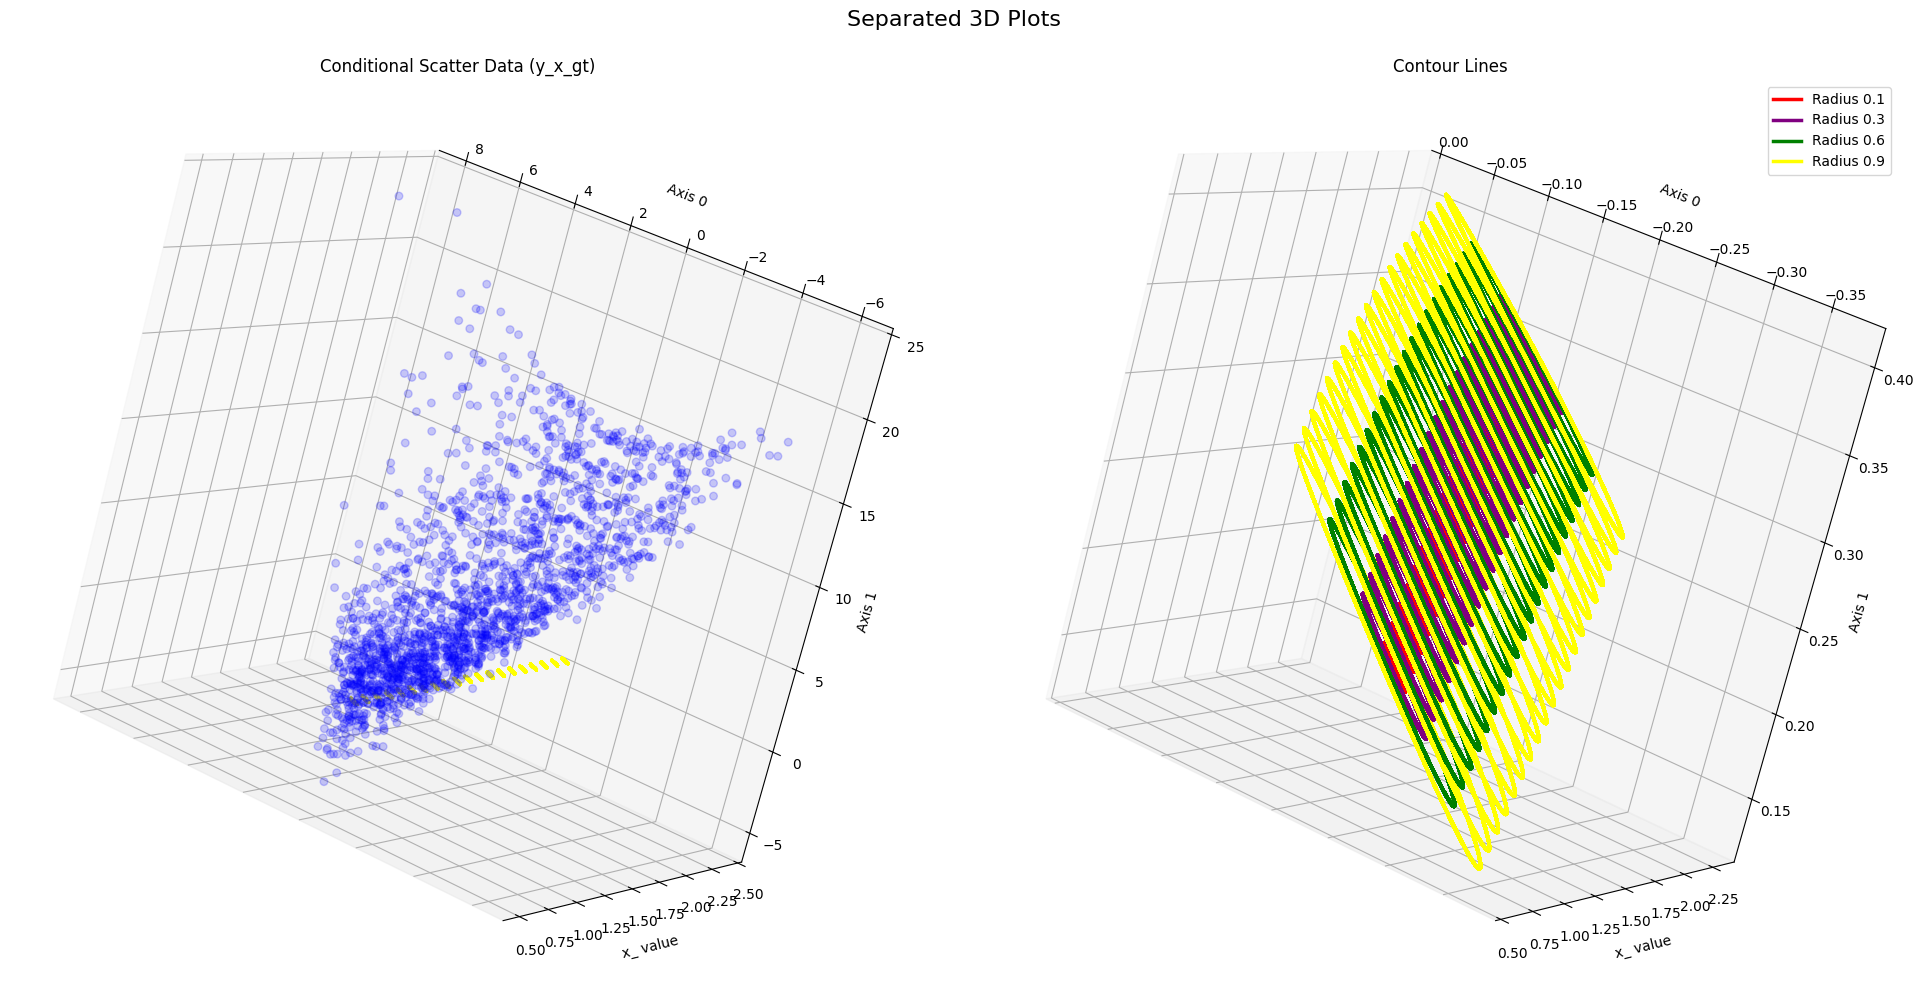

In [18]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline

from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(100, 1))

    colors = ['red', 'purple', 'green', 'yellow']
    radii = [0.1, 0.3, 0.6, 0.9]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = potential_network(torch.cat([u_tensor, x], dim=1))
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

We can add additional parameter update loop with frozen network weights to prevent the quantile crossing effect.

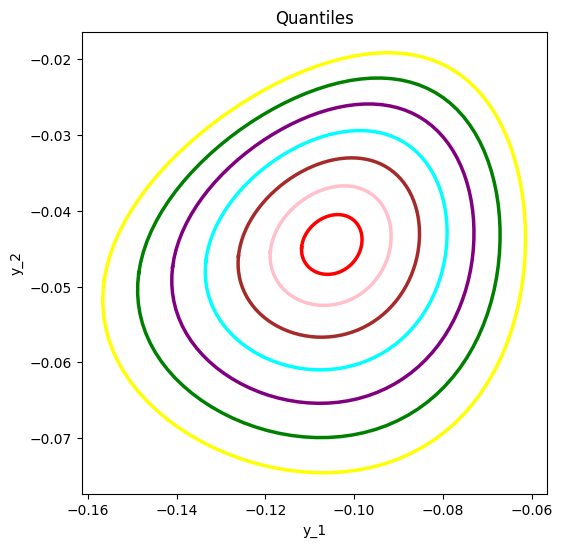

In [9]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = torch.tensor([1.], **device_and_dtype_specifications)[:, None]


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow']
radii = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = potential_network(torch.cat([u_tensor, x.repeat(repeats=(100, 1))], dim=1))
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)
